# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [104]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn import tree

import graphviz

%matplotlib inline

import warnings
# Suprimir todos os RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [105]:
df = pd.read_csv('previsao_de_renda.csv')
df_renda = df.drop(columns=['Unnamed: 0', 'data_ref', 'id_cliente']).dropna()
df_renda = pd.get_dummies(df_renda,drop_first=True).astype(float)


In [106]:
## para renomear colunas
def renomear_colunas(df):
    df.columns = df.columns.str.replace(' ', '_')
    return df

## para gerar a string do modelo
def criarModelo (inicio,colunas):
    modelo = inicio +' ~ '
    for x in range(len(colunas)):
        modelo = modelo + colunas[x]
        if x < len(colunas)-1:
            modelo = modelo + ' + '
    return modelo

In [107]:
df_renda = renomear_colunas(df_renda)
tipo = criarModelo('renda',df_renda.drop(columns=['renda']).columns)
tipo

'renda ~ posse_de_veiculo + posse_de_imovel + qtd_filhos + idade + tempo_emprego + qt_pessoas_residencia + sexo_M + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista + tipo_renda_Servidor_público + educacao_Pós_graduação + educacao_Secundário + educacao_Superior_completo + educacao_Superior_incompleto + estado_civil_Separado + estado_civil_Solteiro + estado_civil_União + estado_civil_Viúvo + tipo_residencia_Casa + tipo_residencia_Com_os_pais + tipo_residencia_Comunitário + tipo_residencia_Estúdio + tipo_residencia_Governamental'

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [108]:
#1)Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
df_train, df_test= train_test_split(df_renda, test_size=0.25, random_state=42)
print(df_train.shape, df_test.shape)


(9320, 25) (3107, 25)


In [109]:
tipo = 'np.log(renda) ~ posse_de_veiculo + posse_de_imovel + qtd_filhos + idade + tempo_emprego + qt_pessoas_residencia + sexo_M + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista + tipo_renda_Servidor_público + educacao_Pós_graduação + educacao_Secundário + educacao_Superior_completo + educacao_Superior_incompleto + estado_civil_Separado + estado_civil_Solteiro + estado_civil_União + estado_civil_Viúvo + tipo_residencia_Casa + tipo_residencia_Com_os_pais + tipo_residencia_Comunitário + tipo_residencia_Estúdio + tipo_residencia_Governamental'
y_test, X_test = patsy.dmatrices(tipo, data = df_test)
y_train, X_train = patsy.dmatrices(tipo, data = df_train)


In [114]:
#2)Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?

print('Para RIDGE foi usado valor de L1_wt = 0.0000001, segundo orientação do Tutor\n\n')
alpha_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

for x in alpha_list:
    md = sm.OLS(y_test,X_test)
    reg = md.fit_regularized(alpha=x,L1_wt=0.0000001,refit=True)
    
    print(f'Alpha = {x} || R² = {reg.rsquared:.4f} || R²-Adj = {reg.rsquared_adj:.4f} || AIC = {reg.aic:.4f}')


print('\n\nValidando R² "from sklearn.linear_model import Ridge"\n')

for x in alpha_list:
    ridge_md = Ridge(alpha=x).fit(X_test, y_test)
    print(ridge_md.score(X_test,y_test))

print('\n\n Não foi possível verificar um melhor modelo RIDGE para valores de Alpha\n\n')

Para RIDGE foi usado valor de L1_wt = 0.0000001, segundo orientação do Tutor


Alpha = 0 || R² = 0.3711 || R²-Adj = 0.3662 || AIC = 6789.9662
Alpha = 0.001 || R² = 0.3711 || R²-Adj = 0.3664 || AIC = 6787.9662
Alpha = 0.005 || R² = 0.3711 || R²-Adj = 0.3664 || AIC = 6787.9662
Alpha = 0.01 || R² = 0.3711 || R²-Adj = 0.3664 || AIC = 6787.9662
Alpha = 0.05 || R² = 0.3711 || R²-Adj = 0.3664 || AIC = 6787.9662
Alpha = 0.1 || R² = 0.3711 || R²-Adj = 0.3664 || AIC = 6787.9662


Validando R² "from sklearn.linear_model import Ridge"

0.37111763464791103
0.3711176340629534
0.3711176202991793
0.37111757858378824
0.3711164604271423
0.3711137819096385


 Não foi possível verificar um melhor modelo RIDGE para valores de Alpha




In [115]:
#3)Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
alpha_list = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

for x in alpha_list:
    md = sm.OLS(y_test,X_test)
    reg = md.fit_regularized(alpha=x,L1_wt=1,refit=True)
    
    print(f'Alpha = {x} || R² = {reg.rsquared:.4f} || R²-Adj = {reg.rsquared_adj:.4f} || AIC = {reg.aic:.4f}')
    

print('\n\nMelhor valor de Alpha para LASSO foi 0 com R² maior')

Alpha = 0 || R² = 0.3711 || R²-Adj = 0.3662 || AIC = 6789.9662
Alpha = 0.001 || R² = 0.3704 || R²-Adj = 0.3669 || AIC = 6779.5013
Alpha = 0.005 || R² = 0.3688 || R²-Adj = 0.3664 || AIC = 6777.3276
Alpha = 0.01 || R² = 0.3628 || R²-Adj = 0.3613 || AIC = 6797.0036
Alpha = 0.05 || R² = 0.3604 || R²-Adj = 0.3594 || AIC = 6804.2696
Alpha = 0.1 || R² = 0.3604 || R²-Adj = 0.3594 || AIC = 6804.2696


Melhor valor de Alpha para LASSO foi 0 com R² maior


In [116]:
#4)Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
# Carregando a base de dados 
data = df_test

# Convertendo variáveis categóricas em variáveis dummy
X = pd.get_dummies(data.drop(columns='renda'), drop_first=True)
y = data['renda']

# Garantindo que todas as colunas de X sejam do tipo float
X = X.astype(float)

# Garantindo que y seja do tipo float
y = y.astype(float)

# Função de seleção stepwise
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out=0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        # começamos pela lista de variaveis excluidas
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=np.float64)
        # para que toda variavel excluida vá sendo incluida e o p-value armazenado
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        # vai retirando as váriaveis menos significantes
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Executando a seleção stepwise
variaveis = stepwise_selection(X, y)

print('resulting features:')
print(variaveis)

Add  tempo_emprego                  with p-value 8.47062e-122
Add  sexo_M                         with p-value 8.19909e-117
Add  educacao_Superior_completo     with p-value 0.000226477
Add  idade                          with p-value 0.000382414
Add  posse_de_veiculo               with p-value 0.00320998
Add  tipo_renda_Empresário          with p-value 0.0138968
Add  qt_pessoas_residencia          with p-value 0.0203004
Add  tipo_residencia_Estúdio        with p-value 0.0358094
resulting features:
['tempo_emprego', 'sexo_M', 'educacao_Superior_completo', 'idade', 'posse_de_veiculo', 'tipo_renda_Empresário', 'qt_pessoas_residencia', 'tipo_residencia_Estúdio']


In [117]:

tipo = 'np.log(renda) ~ tempo_emprego + sexo_M + educacao_Superior_completo + idade + posse_de_veiculo + tipo_renda_Empresário + qt_pessoas_residencia + tipo_residencia_Estúdio'
md = smf.ols(tipo, data = df_test)
reg4 = md.fit()
print(f'R²: {reg4.rsquared}')
reg4.summary()


R²: 0.3688909561815952


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     226.4
Date:                Mon, 20 Jan 2025   Prob (F-statistic):          7.20e-303
Time:                        08:11:17   Log-Likelihood:                -3374.5
No. Observations:                3107   AIC:                             6767.
Df Residuals:                    3098   BIC:                             6821.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.0820      0.078     90.796      0.000       6.929       7.235
tempo_emprego                  0.0645      0.002     30.818      0.000       0.060       0.069
sexo_M                         0.7743      0.029     26.568      0.000       0.717       0.831
educacao_Superior_completo     0.1032      0.027      3.824      0.000       0.050       0.156
idade                          0.0056      0.002      3.719      0.000       0.003       0.009
posse_de_veiculo               0.0968      0.028      3.418      0.001       0.041       0.152
tipo_renda_Empresário          0.1183      0.029      4.140      0.000       0.062       0.174
qt_pessoas_residencia          0.0218      0.014      1.602      0.109      -0.005       0.049
tipo_residencia_Estúdio        0.4652      0.180      2.577      0.010       0.111       0.819
==============================================================================
Omnibus:                        0.170   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.918   Jarque-Bera (JB):                0.210
Skew:                           0.012   Prob(JB):                        0.900
Kurtosis:                       2.967   Cond. No.                         593.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [181]:
#5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?


Resposta: Modelo do Item 4 é o que possui melhor AIC e Adj. R-squared

In [118]:
#6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

tipo = 'np.log(renda) ~ (tempo_emprego + np.power(tempo_emprego,2)) + sexo_M + educacao_Superior_completo + idade + posse_de_veiculo + tipo_renda_Empresário + tipo_residencia_Estúdio'
md = smf.ols(tipo, data = df_test)
reg6 = md.fit()
reg6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     228.5
Date:                Mon, 20 Jan 2025   Prob (F-statistic):          3.44e-305
Time:                        08:11:39   Log-Likelihood:                -3369.1
No. Observations:                3107   AIC:                             6756.
Df Residuals:                    3098   BIC:                             6811.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.0766      0.067    105.335      0.000       6.945       7.208
tempo_emprego                  0.0824      0.005     15.560      0.000       0.072       0.093
np.power(tempo_emprego, 2)    -0.0007      0.000     -3.649      0.000      -0.001      -0.000
sexo_M                         0.7760      0.029     26.699      0.000       0.719       0.833
educacao_Superior_completo     0.1070      0.027      3.970      0.000       0.054       0.160
idade                          0.0054      0.001      3.649      0.000       0.002       0.008
posse_de_veiculo               0.0971      0.028      3.451      0.001       0.042       0.152
tipo_renda_Empresário          0.1147      0.028      4.033      0.000       0.059       0.171
tipo_residencia_Estúdio        0.4462      0.180      2.476      0.013       0.093       0.800
==============================================================================
Omnibus:                        0.187   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.911   Jarque-Bera (JB):                0.231
Skew:                           0.010   Prob(JB):                        0.891
Kurtosis:                       2.962   Cond. No.                     2.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:
#7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

arvore_reg = DecisionTreeRegressor(max_depth=5,random_state=42)
arvore_reg.fit(X_train, y_train)

y_pred = arvore_reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'R² da árvore de regressão: {r2:.4f}')

R² da árvore de regressão: 0.3754


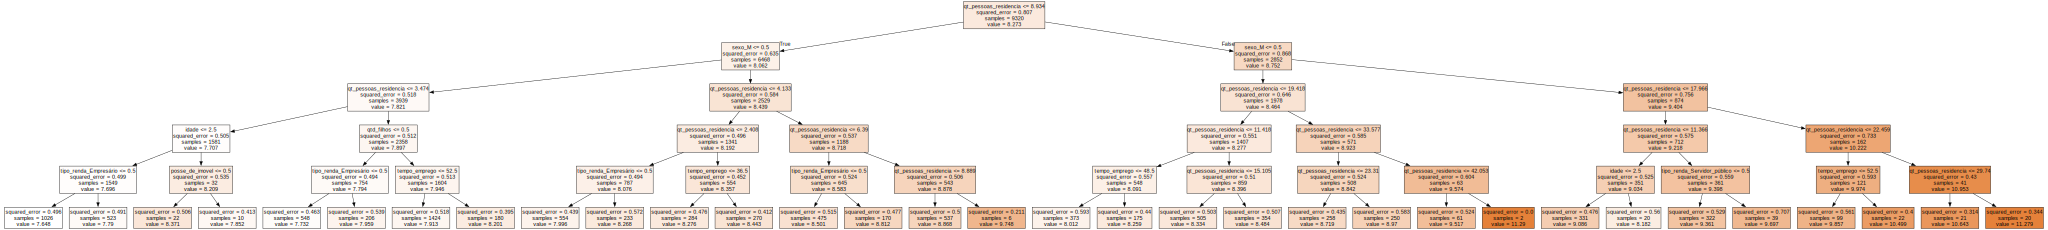

In [126]:
# plot arvore
dot_data2 = tree.export_graphviz(arvore_reg, feature_names=df_test.columns, filled=True, out_file=None)
graphviz.Source(dot_data2)
